## CA4021 Assignment 1 - Random Forest and AutoML

In this notebook, I build machine learning models to predict whether patients in the dataset have diabetes or not using both AutoML and Ensemble methods (Random Forest).

I will use **roc-AUC** and **accuracy scores** as performance metrics for evaluating model performance.
<br>
  
Notebook authored by Joseph Oluwasanya

### 1. Importing libraries and data

In [1]:
# Data Wrangling & Visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Modelling
from sklearn.metrics import auc, accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from pycaret.classification import *

seed = 42
    

In [2]:
df = pd.read_csv('../data/diabetes.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [3]:
response = 'Outcome'
predictors = [col for col in df.columns if col != response]
predictors

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### 2. Exploratory data analysis

In [4]:
# no missing values
df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Histogram and density plot of Pregnancies


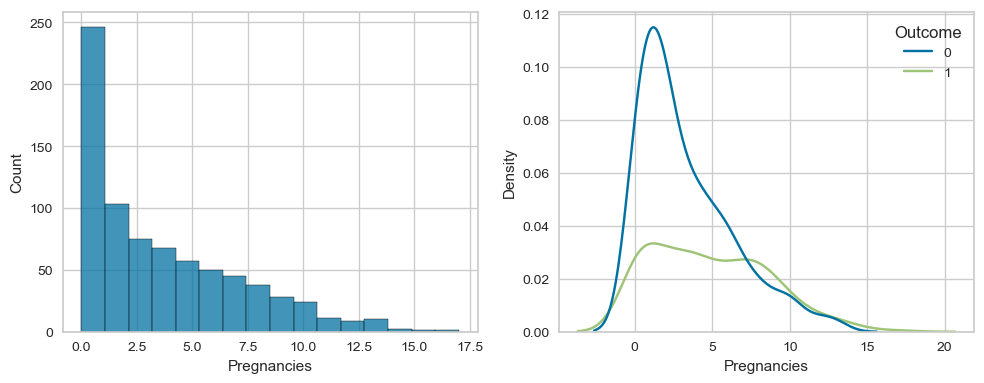

Histogram and density plot of Glucose


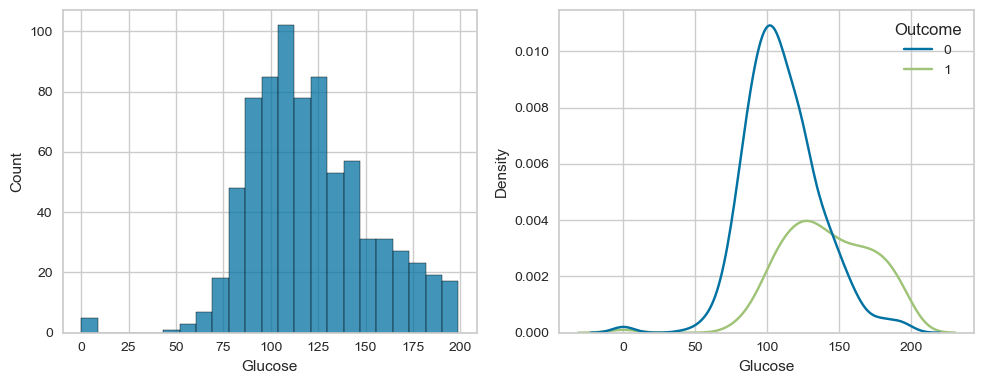

Histogram and density plot of BloodPressure


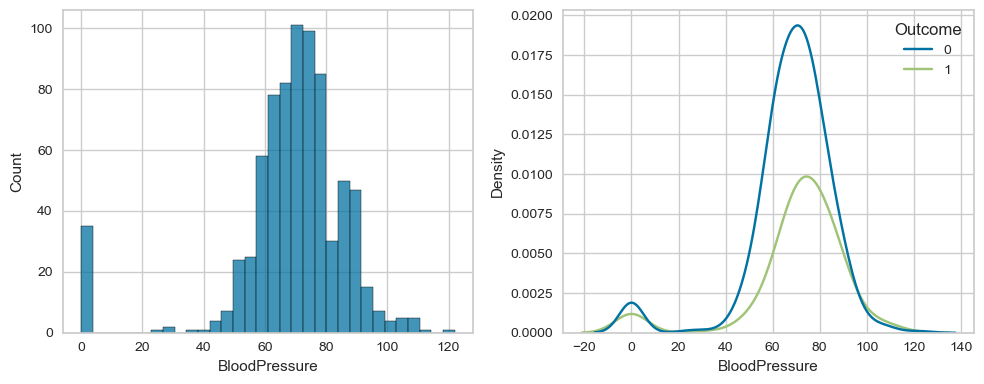

Histogram and density plot of SkinThickness


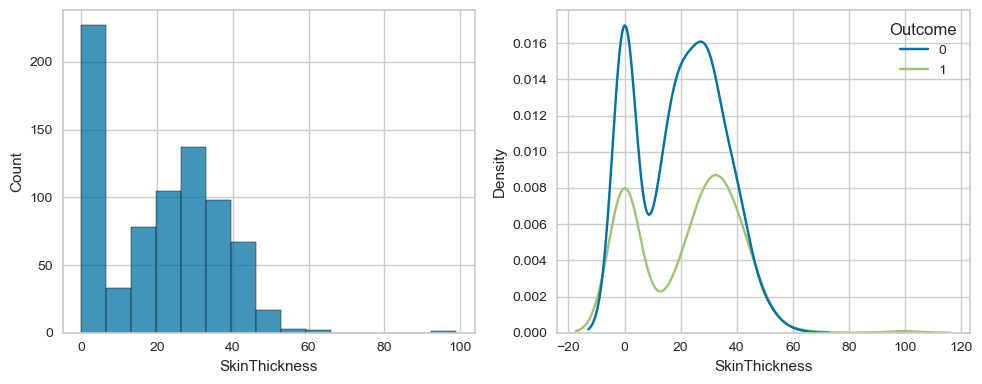

Histogram and density plot of Insulin


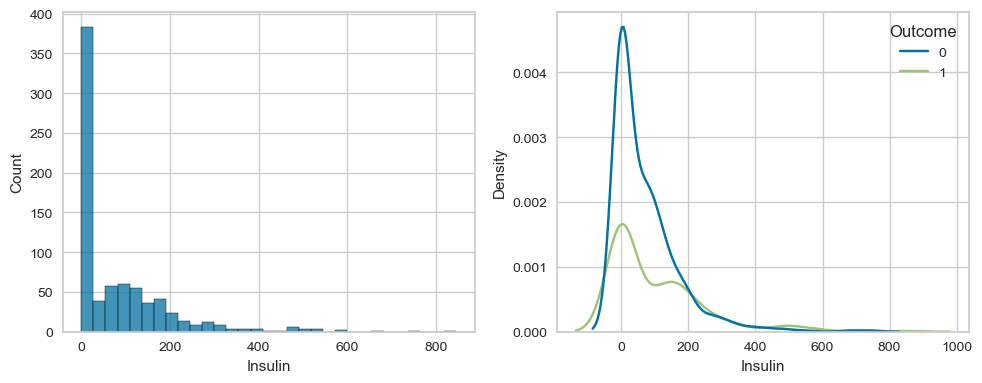

Histogram and density plot of BMI


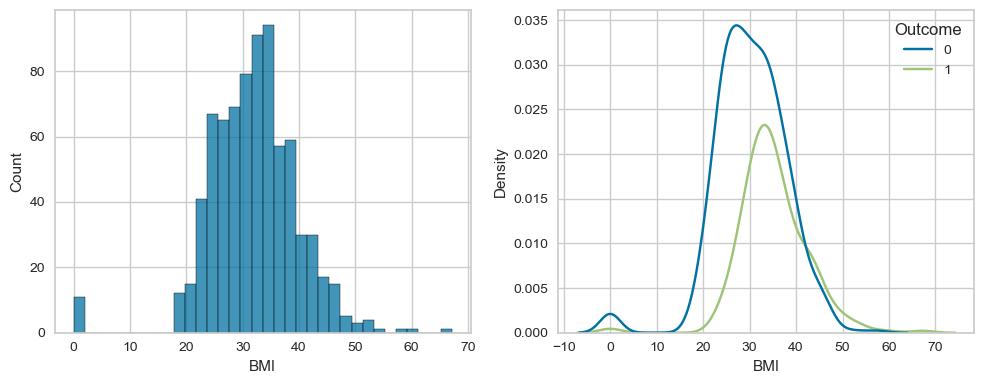

Histogram and density plot of DiabetesPedigreeFunction


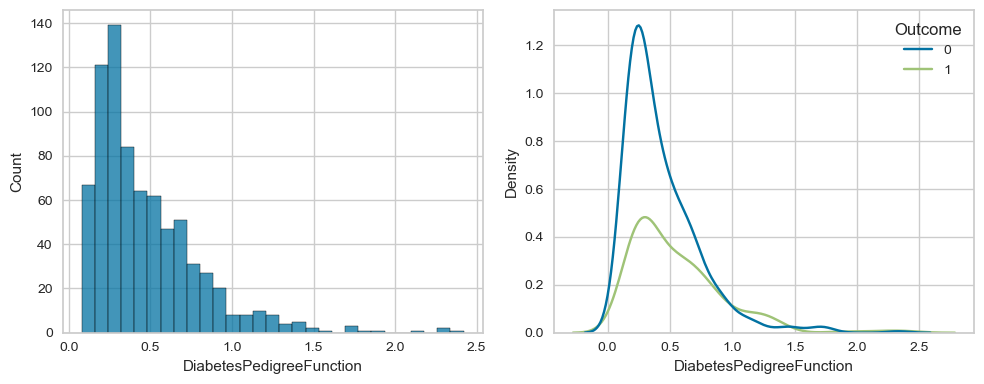

Histogram and density plot of Age


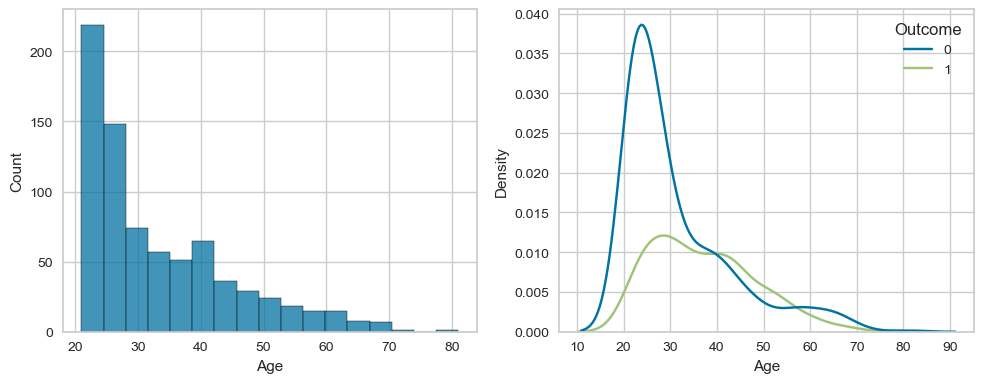

In [6]:
# all the features are numeric, so we will check the distributions using histograms. 
# We can also check the difference in distribution between the response groups
for f in predictors:
    print("Histogram and density plot of", f)
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 4))
    
    sns.histplot(x=f, data=df, ax = ax1)
    sns.kdeplot(x=f, data=df, hue=response, ax = ax2)
    
    plt.tight_layout()
    plt.show()

Glucose level shows linear correlation with Diabetes.
The other linear correlations mostly appear insignificant. Note that we're using pearson correlation which works best with 2 continuous variables, and finds linear correlation only.
We will first be using Random forest which is a tree-based model, so non-linear relationships will also be leveraged.

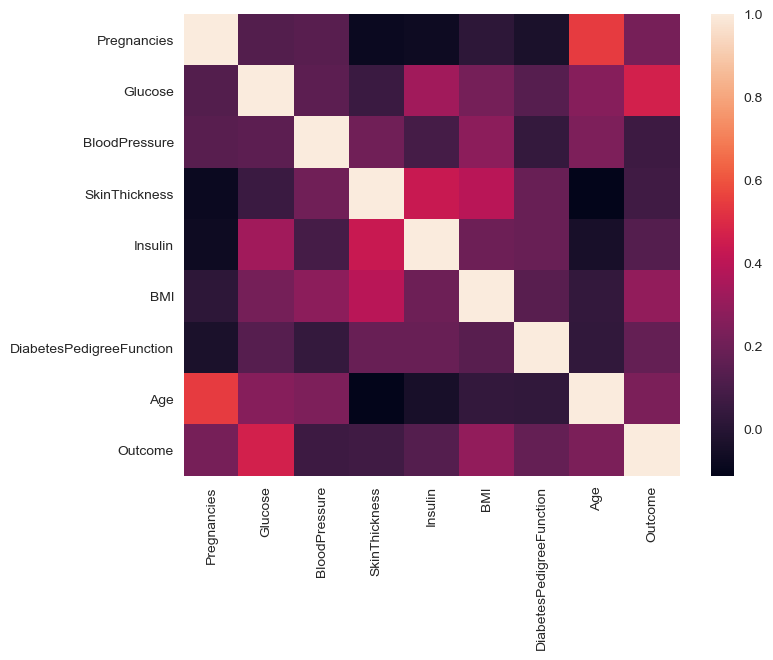

In [7]:
# now let's check the correlation between different variables with the response variable
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr())

plt.show()

### Modelling

Data is tidy, there aren't any missing valus and since we're using a tree-based model and AutoML, it doesn't require normalization.

In [8]:
X = df[predictors]
y = df[response]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
X_train.shape, X_test.shape


((576, 8), (192, 8))

#### Random Forest

Using **Default parameters** the random forest classifier on the test data was **73.44% Accurate** with **0.7164 AUC**.



##### Default parameters

In [9]:
# default parameters
rf1 = RandomForestClassifier(random_state=seed)

In [10]:
rf1_accuracy = cross_val_score(rf1, X_train, y_train, cv=5, scoring='accuracy', verbose=0)
rf1_auc = cross_val_score(rf1, X_train, y_train, cv=5, scoring='roc_auc', verbose=0)
print('Random Forest Accuracy (Cross validated):', np.round(rf1_accuracy.mean(), 4))
print('Random Forest AUC (Cross Validated):', np.round(rf1_auc.mean(), 4))

Random Forest Accuracy (Cross validated): 0.776
Random Forest AUC (Cross Validated): 0.8368


In [11]:
# rf1 on test data
rf1.fit(X_train, y_train)
rf1_test_accuracy = accuracy_score(y_test, rf1.predict(X_test))
rf1_test_auc = roc_auc_score(y_test, rf1.predict(X_test))

print('Random Forest Accuracy (Test set):', np.round(rf1_test_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf1_test_auc.mean(), 4))


Random Forest Accuracy (Test set): 0.7344
Random Forest AUC (Test set): 0.7163


##### Hyperparameter tuning

Here, we tune the following hyperparameters of the random forest model using RandomisedSearchCV:

- n_estimators  
- max_depth  
- min_sample_split
- min_samples_leaf  
- max_leaf_nodes  
- max_features




In [12]:
# creating random grid for running the randomised search

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num=10)]
max_depth = [int(x) for x in np.linspace(2, 50, num = 10)]
max_features = ['auto', 'sqrt']
min_samples_split = np.arange(2, 17, 2)
min_samples_leaf = [int(x) for x in np.arange(1, 11, 1)]
max_leaf_nodes = [int(x) for x in np.linspace(10, 50, 10)]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes': max_leaf_nodes
               }

random_grid

{'n_estimators': [100, 311, 522, 733, 944, 1155, 1366, 1577, 1788, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [2, 7, 12, 18, 23, 28, 34, 39, 44, 50],
 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'max_leaf_nodes': [10, 14, 18, 23, 27, 32, 36, 41, 45, 50]}

In [13]:
rf2  =RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator=rf2, param_distributions=random_grid, n_iter=100, cv=3, verbose=2, random_state=seed)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=1788, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=18, max_features=sqrt, max_depth=39 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=1788, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=18, max_features=sqrt, max_depth=39, total=   2.4s
[CV] n_estimators=1788, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=18, max_features=sqrt, max_depth=39 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  n_estimators=1788, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=18, max_features=sqrt, max_depth=39, total=   2.4s
[CV] n_estimators=1788, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=18, max_features=sqrt, max_depth=39 
[CV]  n_estimators=1788, min_samples_split=8, min_samples_leaf=5, max_leaf_nodes=18, max_features=sqrt, max_depth=39, total=   2.4s
[CV] n_estimators=1577, min_samples_split=14, min_samples_leaf=6, max_leaf_nodes=23, max_features=auto, max_depth=50 
[CV]  n_estimators=1577, min_samples_split=14, min_samples_leaf=6, max_leaf_nodes=23, max_features=auto, max_depth=50, total=   2.2s
[CV] n_estimators=1577, min_samples_split=14, min_samples_leaf=6, max_leaf_nodes=23, max_features=auto, max_depth=50 
[CV]  n_estimators=1577, min_samples_split=14, min_samples_leaf=6, max_leaf_nodes=23, max_features=auto, max_depth=50, total=   2.1s
[CV] n_estimators=1577, min_samples_split=14, min_samples_leaf=6, max_leaf_nodes=23, max_features=auto, max_depth=50 

[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.4min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   param_distributions={'max_depth': [2, 7, 12, 18, 23, 28, 34,
                                                      39, 44, 50],
                                        'max_features': ['auto', 'sqrt'],
                                        'max_leaf_nodes': [10, 14, 18, 23, 27,
                                                           32, 36, 41, 45, 50],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16]),
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000]},
                   random_state=42, verbose=2)

In [14]:
rf_random.best_params_

{'n_estimators': 1577,
 'min_samples_split': 2,
 'min_samples_leaf': 6,
 'max_leaf_nodes': 45,
 'max_features': 'auto',
 'max_depth': 28}

In [15]:
rf2_tuned = rf_random.best_estimator_
rf2_tuned_accuracy = accuracy_score(rf2_tuned.predict(X_test), y_test)
rf2_tuned_auc = roc_auc_score(rf2_tuned.predict(X_test), y_test)

In [16]:

print('Random Forest Accuracy (Test set):', np.round(rf2_tuned_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf2_tuned_auc.mean(), 4))


Random Forest Accuracy (Test set): 0.7552
Random Forest AUC (Test set): 0.7344


In [17]:
# Compare performance to RF with default parameters
print('Random Forest Accuracy (Test set):', np.round(rf1_test_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf1_test_auc.mean(), 4))

Random Forest Accuracy (Test set): 0.7344
Random Forest AUC (Test set): 0.7163


##### Extra testing

Here, I tried different numbers of trees and investigated the effect this has on the Accuracy and AUC metrics.

Result: Accuracy peaked at **77.95%** with 600 trees during test validation. Although against the unseen test set, the model performed the same as without modifying this parameter (default is 100 trees)


In [19]:
# Trying different numbers of estimators

rf_accuracy_lst = []
rf_auc_lst = []

n_trees = np.arange(100, 2001, 100)

print("Cross validated metrics for different numbers of trees")
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=seed)

    rf_accuracy = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy').mean()
    rf_auc = cross_val_score(rf, X_train, y_train, cv=5, scoring='roc_auc', verbose=0).mean()
    
    print("n-trees =", n,"| Accuracy:", np.round(rf_accuracy, 4),"| AUC:", np.round(rf_auc, 4))
    print("-"*100)


    rf_accuracy_lst.append(rf_accuracy)
    rf_auc_lst.append(rf_auc)



Cross validated metrics for different numbers of trees
n-trees = 100 | Accuracy: 0.776 | AUC: 0.8368
----------------------------------------------------------------------------------------------------
n-trees = 200 | Accuracy: 0.7708 | AUC: 0.8373
----------------------------------------------------------------------------------------------------
n-trees = 300 | Accuracy: 0.7673 | AUC: 0.8377
----------------------------------------------------------------------------------------------------
n-trees = 400 | Accuracy: 0.7673 | AUC: 0.8387
----------------------------------------------------------------------------------------------------
n-trees = 500 | Accuracy: 0.776 | AUC: 0.8388
----------------------------------------------------------------------------------------------------
n-trees = 600 | Accuracy: 0.7795 | AUC: 0.8381
----------------------------------------------------------------------------------------------------
n-trees = 700 | Accuracy: 0.7743 | AUC: 0.838
-------------

In [21]:

rf_scores = pd.DataFrame({'estimators': n_trees, 'accuracy': rf_accuracy_lst, 'auc': rf_auc_lst})
rf_scores.head()


,estimators,accuracy,auc
0,100,0.775967,0.836788
1,200,0.770780,0.837275
2,300,0.767316,0.837710
3,400,0.767316,0.838675
4,500,0.775997,0.838837


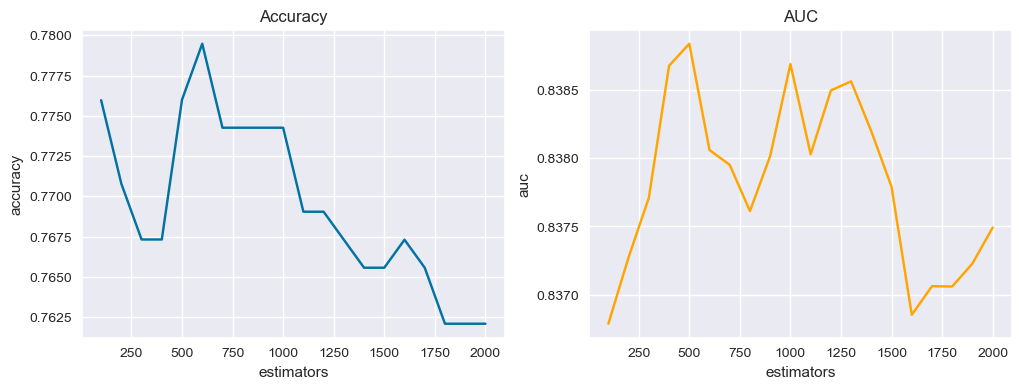

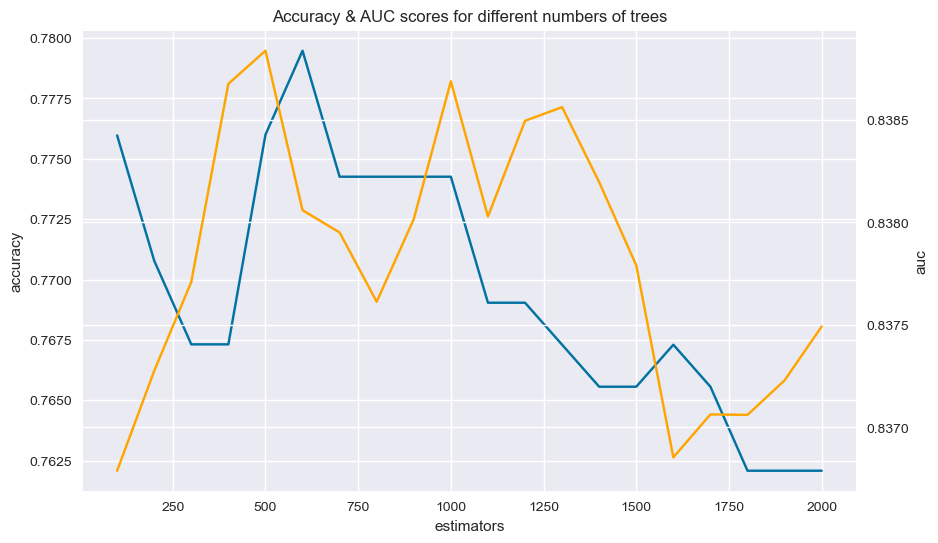

In [22]:
sns.set_style('darkgrid')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))


sns.lineplot(x='estimators', y='accuracy', data=rf_scores, ax=axs[0])
axs[0].set_title('Accuracy')

sns.lineplot(x='estimators', y='auc', data=rf_scores, ax=axs[1], color='orange')
axs[1].set_title('AUC')

fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))
ax2 = ax1.twinx()


sns.lineplot(x='estimators', y='accuracy', data=rf_scores, ax=ax1)
sns.lineplot(x='estimators', y='auc', data=rf_scores, ax=ax2, color='orange')
plt.title('Accuracy & AUC scores for different numbers of trees')
plt.show()


In [25]:
trees = int(rf_scores.loc[np.argmax(a=rf_scores['accuracy']), ['estimators']])
trees

600

In [26]:
# Now testing RF model with 600 trees against the test set
rf3 = RandomForestClassifier(n_estimators=trees, random_state=seed)

rf3.fit(X_train, y_train)
rf3_test_accuracy = accuracy_score(y_test, rf3.predict(X_test))
rf3_test_auc = roc_auc_score(y_test, rf3.predict(X_test))

print('Random Forest Accuracy (Test set):', np.round(rf3_test_accuracy.mean(), 4))
print('Random Forest AUC (Test set):', np.round(rf3_test_auc.mean(), 4))



Random Forest Accuracy (Test set): 0.7344
Random Forest AUC (Test set): 0.7131


#### AutoML

How it works:

**PyCaret** is one of the popular open-source libraries in python which facilitate AutoML (Automated machine learning). It is a low-code library which allows for users to easily automate machine learning workflows using a number of high-level functions. As long as the training data is read into a pandas data frame, and the test set is in another separate data frame, the rest can be done using PyCaret. The Pycaret workflow generalized to be able to handle classification, regression, clustering, and anomaly detection with the almost the exact same code. For this assignment, we used PyCaret’s AutoML framework for a classification task.

https://pycaret.readthedocs.io/en/latest/api/classification.html

Automated preprocessing:
The first step was to pass the training data through a preprocessing function, **“pycaret.classification.setup”**. This function does a sequence of preprocessing steps which are tweakable by overriding its default parameters. In our case, the “Pregnancies” variable was converted to categorical by the setup function’s type inferencing, but this was incorrect. To fix this, I just had to add the argument “numeric_features=[‘Pregnancies’]” in order to manually set the type for that variable. The function outputs a table containing details on the preprocessed data, such as the number of categorical features, and the missing-value imputation method used. **See the PyCaret documentation for a full list of arguments for the function.**

AutoML:
After running the preprocessing step, we can run the AutoML function, pycaret.classification.compare_models, which tries all the machine learning models available in the package using cross validation, ranks them in terms of several performance metrics, and outputs this as a table. The training time for each model (in seconds) is also featured on this table. The highest scores in terms of each metric are highlighted in the resulting table. The metrics are namely: Accuracy, AUC, Precision, Recall, F1, Kappa, and Matthews Correlation Coefficient. The model that performs best in terms of these metrics is returned by the function.


compare_models() is extremely useful, as it would usually take much more time and code to compare the performance of these algorithms at a classification task. Although this doesn’t give a full model diagnostic, it can give clear indication of which algorithms out-of-the-box perform best on our dataset. It also gives us a baseline for comparing to our hand-engineered machine learning models. There is a “fold” argument, which I used here, that defines the number of folds to use for a k-fold cross validation of the different modelling techniques. For a small training set (for example, ~600 rows like I used in this assignment), the function runs in reasonable time (~12 seconds for 10 folds) but for larger datasets it could become expensive to run. Note also that we’re given functionality to run compare_models() as a parallel process, using Spark for example.


Finally, once we select the model PyCaret is able to tune the hyperparameters of the model using pycaret.classification.tune_model. This function also has many optional arguments, but by default runs a random grid search using the sci-kit learn implementation. I inspected the result of hyperparameter tuning by printing the untuned and tuned models.





In [27]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train.shape, test.shape

((576, 9), (192, 9))

In [28]:
# preprocessing
clf = setup(data=train, target=response, session_id=seed, numeric_features=['Pregnancies'])

,Description,Value
0,session_id,42
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(576, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [29]:
# AutoML - model selection
bestmodel = compare_models(fold=5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7717,0.8250,0.6096,0.7036,0.6497,0.4823,0.4874,0.1560
et,Extra Trees Classifier,0.7693,0.8293,0.5249,0.7447,0.6147,0.4568,0.4717,0.0600
rf,Random Forest Classifier,0.7667,0.8344,0.5813,0.7060,0.6347,0.4661,0.4727,0.0660
ridge,Ridge Classifier,0.7592,0.0000,0.5249,0.7063,0.5986,0.4341,0.4450,0.0120
lda,Linear Discriminant Analysis,0.7592,0.8271,0.5320,0.7063,0.6041,0.4371,0.4474,0.0060
lr,Logistic Regression,0.7543,0.8237,0.5320,0.6994,0.6013,0.4288,0.4390,0.7500
nb,Naive Bayes,0.7468,0.7927,0.5397,0.6713,0.5949,0.4152,0.4223,0.0060
knn,K Neighbors Classifier,0.7444,0.7577,0.5246,0.6775,0.5893,0.4083,0.4165,0.4900
gbc,Gradient Boosting Classifier,0.7371,0.8199,0.5672,0.6458,0.6021,0.4071,0.4103,0.0280
qda,Quadratic Discriminant Analysis,0.7245,0.7760,0.5113,0.6247,0.5603,0.3641,0.3687,0.0100


In [30]:
# AutoML - tuning
final_model, tuner = tune_model(bestmodel, return_tuner=True)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7805,0.8995,0.6429,0.6923,0.6667,0.5034,0.5041
1,0.8049,0.8968,0.7143,0.7143,0.7143,0.5661,0.5661
2,0.8537,0.8769,0.6667,0.9091,0.7692,0.6658,0.6829
3,0.7750,0.8434,0.5714,0.7273,0.6400,0.4798,0.4871
4,0.7750,0.7802,0.5714,0.7273,0.6400,0.4798,0.4871
5,0.6500,0.7225,0.5714,0.5000,0.5333,0.2553,0.2568
6,0.6500,0.7253,0.3571,0.5000,0.4167,0.1765,0.1816
7,0.7500,0.7775,0.5714,0.6667,0.6154,0.4318,0.4346
8,0.7750,0.8956,0.7143,0.6667,0.6897,0.5135,0.5143


In [31]:
print(bestmodel)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [32]:
print(final_model)

LGBMClassifier(bagging_fraction=0.8, bagging_freq=7, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=16, min_child_weight=0.001, min_split_gain=0.7,
               n_estimators=100, n_jobs=-1, num_leaves=90, objective=None,
               random_state=42, reg_alpha=1, reg_lambda=3, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [33]:
fm_pred = predict_model(final_model, data=test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7708,0.8049,0.6812,0.6812,0.6812,0.5023,0.5023


In [34]:
predict_model(bestmodel, data=test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7396,0.7847,0.7101,0.6203,0.6622,0.4519,0.4546


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Label,Score
668,6,98,58,33,190,34.0,0.430,43,0,0,0.6318
324,2,112,75,32,0,35.7,0.148,21,0,0,0.9945
624,2,108,64,0,0,30.8,0.158,21,0,0,0.7230
690,8,107,80,0,0,24.6,0.856,34,0,0,0.9686
473,7,136,90,0,0,29.9,0.210,50,0,1,0.5637
...,...,...,...,...,...,...,...,...,...,...,...
554,1,84,64,23,115,36.9,0.471,28,0,0,0.9980
319,6,194,78,0,0,23.5,0.129,59,1,1,0.8580
594,6,123,72,45,230,33.6,0.733,34,0,1,0.9015
6,3,78,50,32,88,31.0,0.248,26,1,0,0.9963


In [35]:
# checking that sklearn metric matches the pycaret metric
np.round(accuracy_score(y_test, fm_pred.Label), 4)

0.7708

### Final Discussion (Comparing the two approaches)

#### Performance:

The results using Random Forest vs AutoML are shown below:

| Method                  | Accuracy | AUC    |
| ----------------------- | -------- | ------ |
| Random Forest (Default) | 0.7344   | 0.7164 |
| AutoML (Default)        | 0.7396   | 0.7847 |
| Random Forest (Tuned)   | 0.7448   | 0.7227 |
| **AutoML (Tuned)**  | **0.7708**   | **0.8049** |

Table 1, performance metrics for RF and AutoML models.


Using default parameters for both approaches, AutoML outperformed the Random Forest model. This was an expected result, as random forest is a a single machine learning ensemble technique, yet AutoML tries a wide variety of machine learning techniques. The **best performing model, selected by AutoML was the Light Gradient Boosting Machine**, an ensembling technique that uses boosting rather than bagging. But the random forest model was close in performance ranking 3rd out of the 14 models. 

The tuned random forest model outperforms the Default AutoML configuration in terms of accuracy, but not AUC. And **the hyperparameter-tuned AutoML model performed best on the test set overall**.

#### Overall:

PyCaret's AutoML implementation makes is very easy to build and compare machine learning models. It's default arguments allow for low-code solutions end-to-end, but it allowed me to make changes to the modelling process as I saw fit, from data preprocessing to hyperparameter tuning. AutoML automatically outputs performance metrics when comparing models or using models to make predictions, making for less code than I used in the hand-engineered random forest approach.

I think that the preprocessing options (in pycaret.classification.setup) for AutoML could be insufficient for more complex and/or untidy data. Although it has optional arguments for missing value imputation and type casting, I'd prefer to do any preprocessing prior to passing data into AutoML, as I would do using the hand-engineered approach also.

The hyperparameter tuning option for AutoML was convenient. I used the default parameters here, while defining an explicit search space for tuning the random forest model. Scikit-learn and Optuna, the two most popular packages for hyperpatameter tuning, are integrated into PyCaret.

A potential downside to using AutoML to select the algorithm to proceed with is that since it trains these models using the default parameters, so the ranking order is partially dependent on how suitable the default parameters are, and on the sensitivity of models to hyperparameter tuning. That being said, I believe AutoML is an incredible tool for quickly assessing where to start when approaching a predictive modelling task. I just wouldn't take the compare_models() results as the only decision factor without further analysis.
